**import**

In [ ]:
# Import Moudles and Packages
import gc
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import random

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

import natsort

import gc
import torch

from mpl_toolkits.axes_grid1 import ImageGrid
from torchsummary import summary
gc.collect()
torch.cuda.empty_cache()

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

print("__Import modules and packages__\n")
print("| Pytorch version: {}".format(torch.__version__))
print("| GPU: {}".format(torch.cuda.is_available()))
print("| Device : ",device)
print("| Device name: ", torch.cuda.get_device_name(0))
print("| Device count: ", torch.cuda.device_count())

**model**

In [ ]:
import timm
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=40)
model.eval()
model.load_state_dict(torch.load(
    f'/home/ubuntu/workspace/FLD-scratch/src/models/pretrained_model/0703/swin_lateral_home_200epoch_20pt.pth',
    map_location = 'cpu'))
model = model.to(device)

In [ ]:
import src.dataset.kface_dataset_lateral_3ch as K_L
import src.dataset.kface_dataset_frontal_3ch as K_F
import src.dataset.kface_transform_A_plus as A

**dataset**

In [ ]:
import src.config as C
k_dataset_train_lateral = K_L.kfacedataset(
    type="train",
    transform=A.get_augmentation(data_type="train")
    )

k_dataset_valid_lateral = K_L.kfacedataset(
    type="valid",
    transform=A.get_augmentation(data_type="valid")
    )

k_dataset_train_frontal = K_F.kfacedataset(
    type="train",
    transform=A.get_augmentation(data_type="train")
    )

k_dataset_valid_frontal = K_F.kfacedataset(
    type="valid",
    transform=A.get_augmentation(data_type="valid")
    )

k_dataset_train = k_dataset_train_frontal+k_dataset_train_lateral
k_dataset_valid = k_dataset_valid_frontal+k_dataset_valid_lateral

In [ ]:
len_train = int(len(k_dataset_train)*0.8)
len_valid = len(k_dataset_train)-len_train

**dataloader**

In [ ]:
train_dataset, _ = D.random_split(k_dataset_train, [len_train, len_valid])
_, valid_dataset = D.random_split(k_dataset_valid, [len_train, len_valid])

BATCH_SIZE = 32

train_loader = D.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = D.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f'{len(train_dataset)} images for training')
print(f'{len(valid_dataset)} images for validating')

**visualization**

In [ ]:
from src.utils.visualize import visualize_image, visualize_batch

image1, landmarks1 = train_dataset[0]
print(image1.shape)
visualize_image(image1, landmarks1)

image2, landmarks2 = train_dataset[0]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_dataset[0]
visualize_image(image3, landmarks3)

In [ ]:
for x, y in train_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in valid_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

In [ ]:
visualize_batch(x[:4], y[:4], y[:4], shape = (2, 2), size = 16, title = 'Training Batch Samples')

**loss and optimizer**

In [ ]:
import torch.optim as optim
objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00002)

**define validation function**

In [ ]:
from tqdm import tqdm
model.eval()
@torch.no_grad()
def validate(save = None):
    cum_loss = 0.0

    for features, labels in valid_loader:
        features = features.to(device)
        labels = labels.to(device)
        
        with autocast(enabled=True):
            outputs = model(features)
            loss = objective(outputs, labels)
            
        cum_loss += loss.item()

        break
        
    visualize_batch(features[:4].cpu(), outputs[:4].cpu(), labels[:4].cpu(),
                    shape = (2, 2), size = 16, title = 'Validation sample predictions', save = save)

    return cum_loss/len(valid_loader)

validate()

In [ ]:
day = "0703"
type = "all_home_add_trans_noresize"
model_name = 'swin'
save_fig_path = f"logs/{day}/kface_progresses_{type}_{model_name}"

In [ ]:
if not os.path.isdir(save_fig_path):
    os.makedirs(save_fig_path)    

Training: 100%|██████████| 778/778 [07:23<00:00,  1.75it/s]


Validation sample predictions


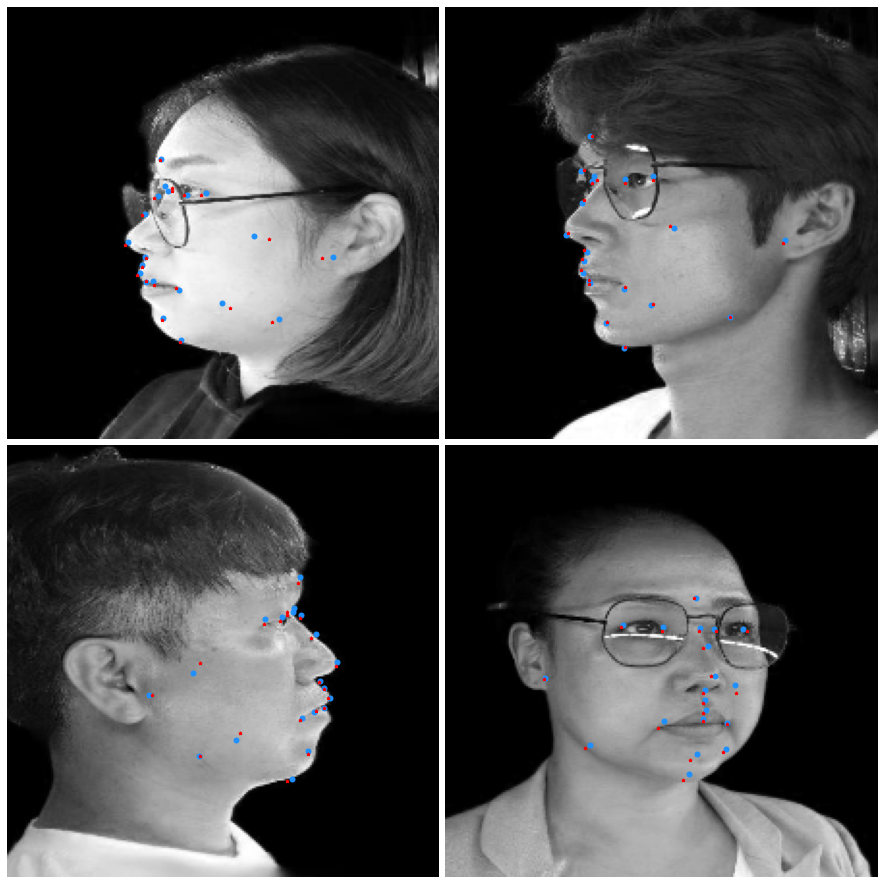

Epoch(14/200) -> Training Loss: 0.00012074 | Validation Loss: 0.00000035


Training: 100%|██████████| 778/778 [07:24<00:00,  1.75it/s]


Validation sample predictions


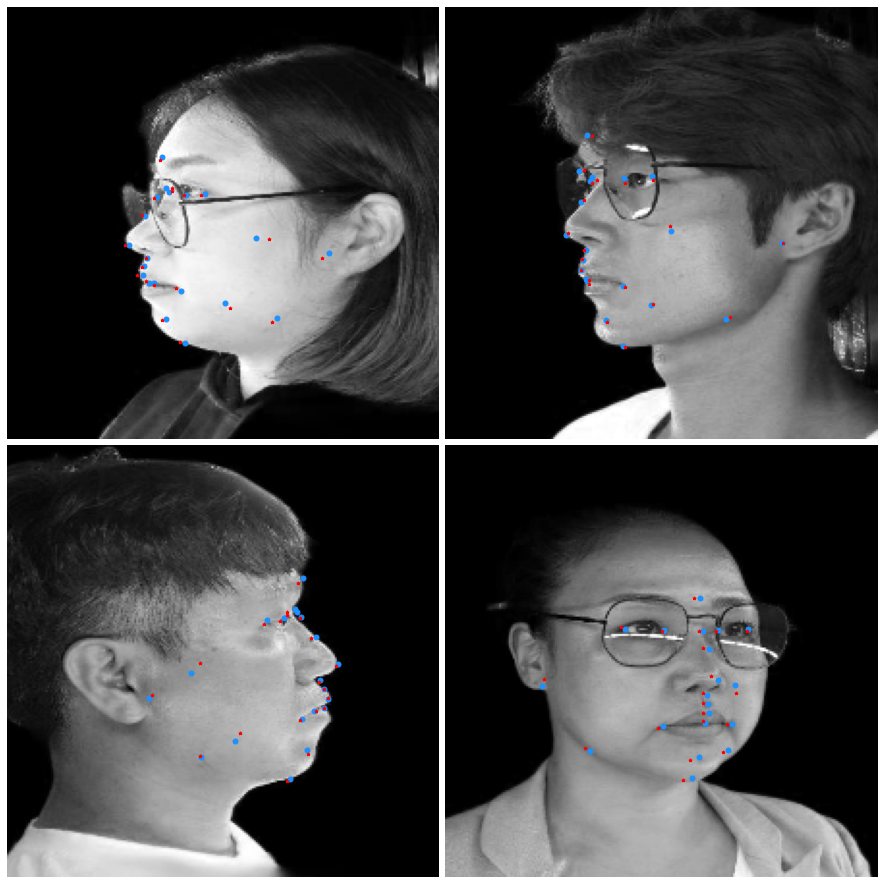

Epoch(15/200) -> Training Loss: 0.00010618 | Validation Loss: 0.00000038


Training: 100%|██████████| 778/778 [07:25<00:00,  1.75it/s]


Validation sample predictions


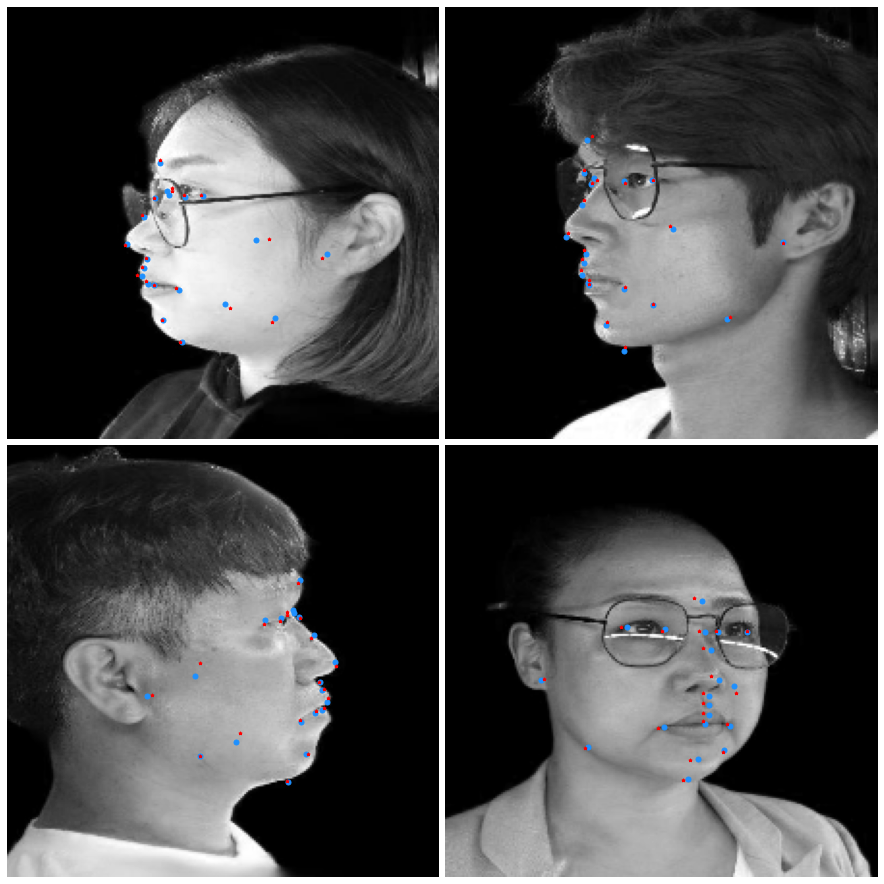

Epoch(16/200) -> Training Loss: 0.00010658 | Validation Loss: 0.00000030


Training: 100%|██████████| 778/778 [07:25<00:00,  1.75it/s]


Validation sample predictions


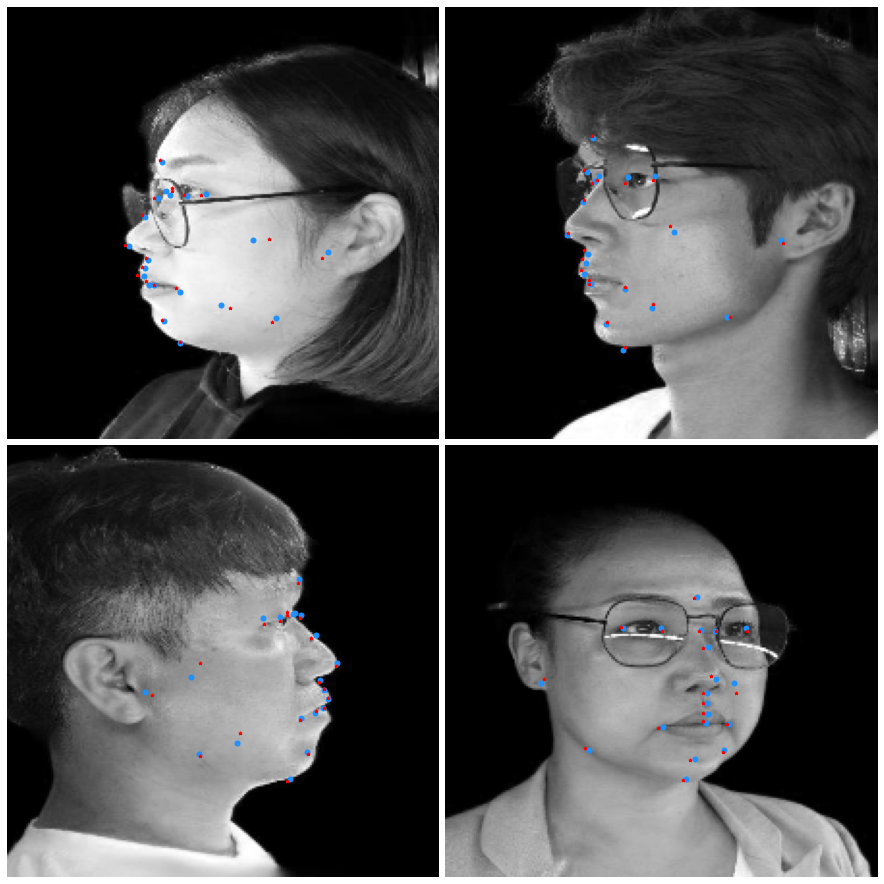

Epoch(17/200) -> Training Loss: 0.00011226 | Validation Loss: 0.00000030


Training: 100%|██████████| 778/778 [07:26<00:00,  1.74it/s]


Validation sample predictions


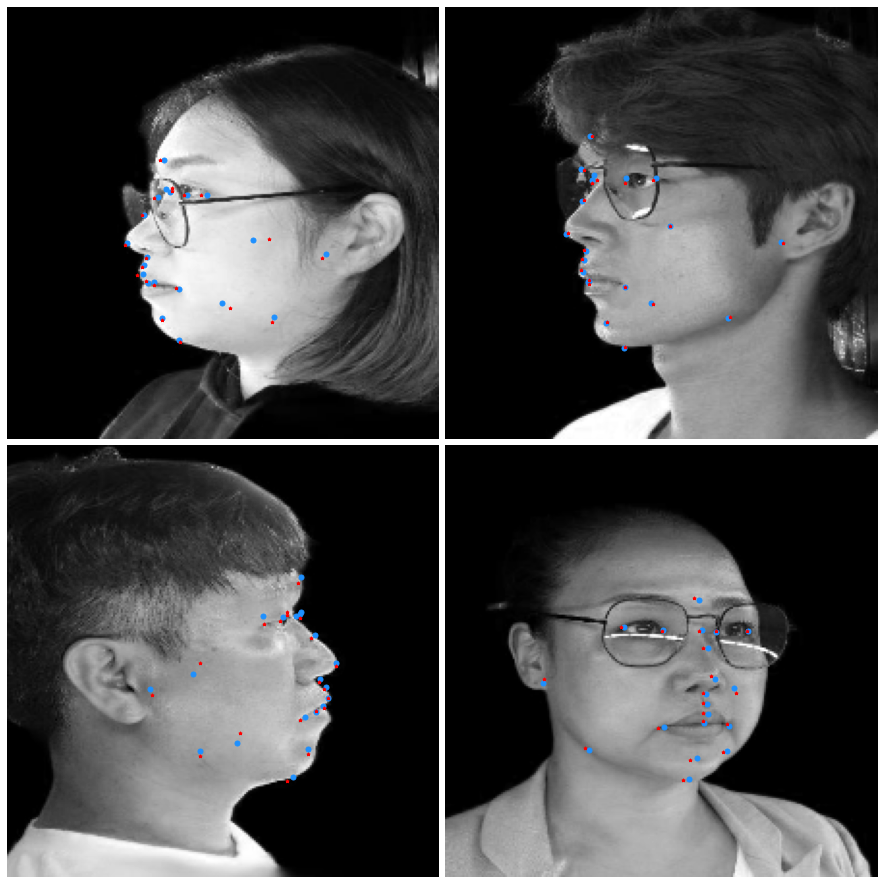

Saving model....................
Epoch(18/200) -> Training Loss: 0.00011625 | Validation Loss: 0.00000026


Training: 100%|██████████| 778/778 [07:26<00:00,  1.74it/s]


Validation sample predictions


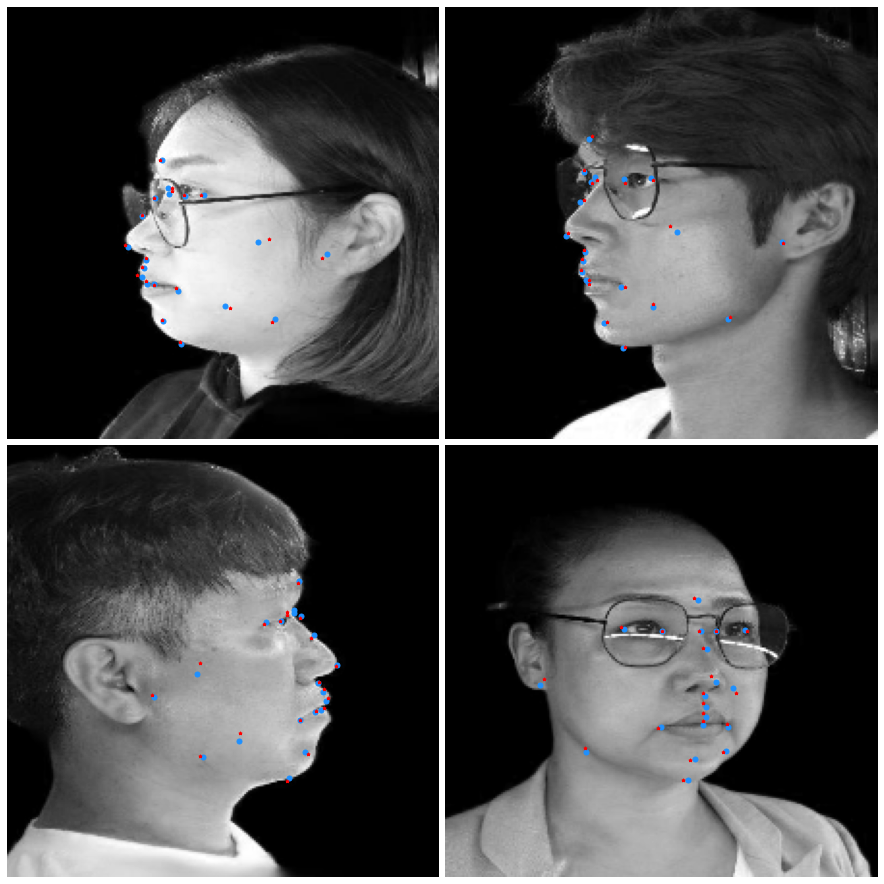

Epoch(19/200) -> Training Loss: 0.00010424 | Validation Loss: 0.00000027


Training:  54%|█████▍    | 424/778 [04:03<03:24,  1.73it/s]

In [14]:
epochs = 200
batches = len(train_loader)
best_loss = np.inf
optimizer.zero_grad()

start_time = time.time()
for epoch in range(epochs):
    cum_loss = 0.0
    scaler = GradScaler() 
    model.train()
    for idx, (features, labels) in enumerate(tqdm(train_loader, desc= 'Training')):
        features = features.to(device)
        labels = labels.to(device)

        with autocast(enabled=True):
            model = model.to(device)
            
            outputs = model(features)
        
            loss = objective(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
                
        optimizer.zero_grad()

        cum_loss += loss.item()
        
    val_loss = validate(os.path.join(f'/home/ubuntu/workspace/FLD-scratch/{save_fig_path}',
                                     f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        save_model = f'/home/ubuntu/workspace/FLD-scratch/src/models/pretrained_model/{day}/{model_name}_{type}_{epochs}epoch_20pt_add_trans_noresize.pth'
        torch.save(model.state_dict(), save_model)

    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))    